In [ ]:
from notebooks import *

In [ ]:
load = Load()
recs = recs if 'recs' in locals() else load.recs(
    # limit=30,  # XXX Faster dev
    datasets=[
        'peterson-field-guide',
        # 'recordings',
    ],
)
display(
    # df_summary(recs).T,
    # df_summary(recs),
    # recs[:5],
)

.

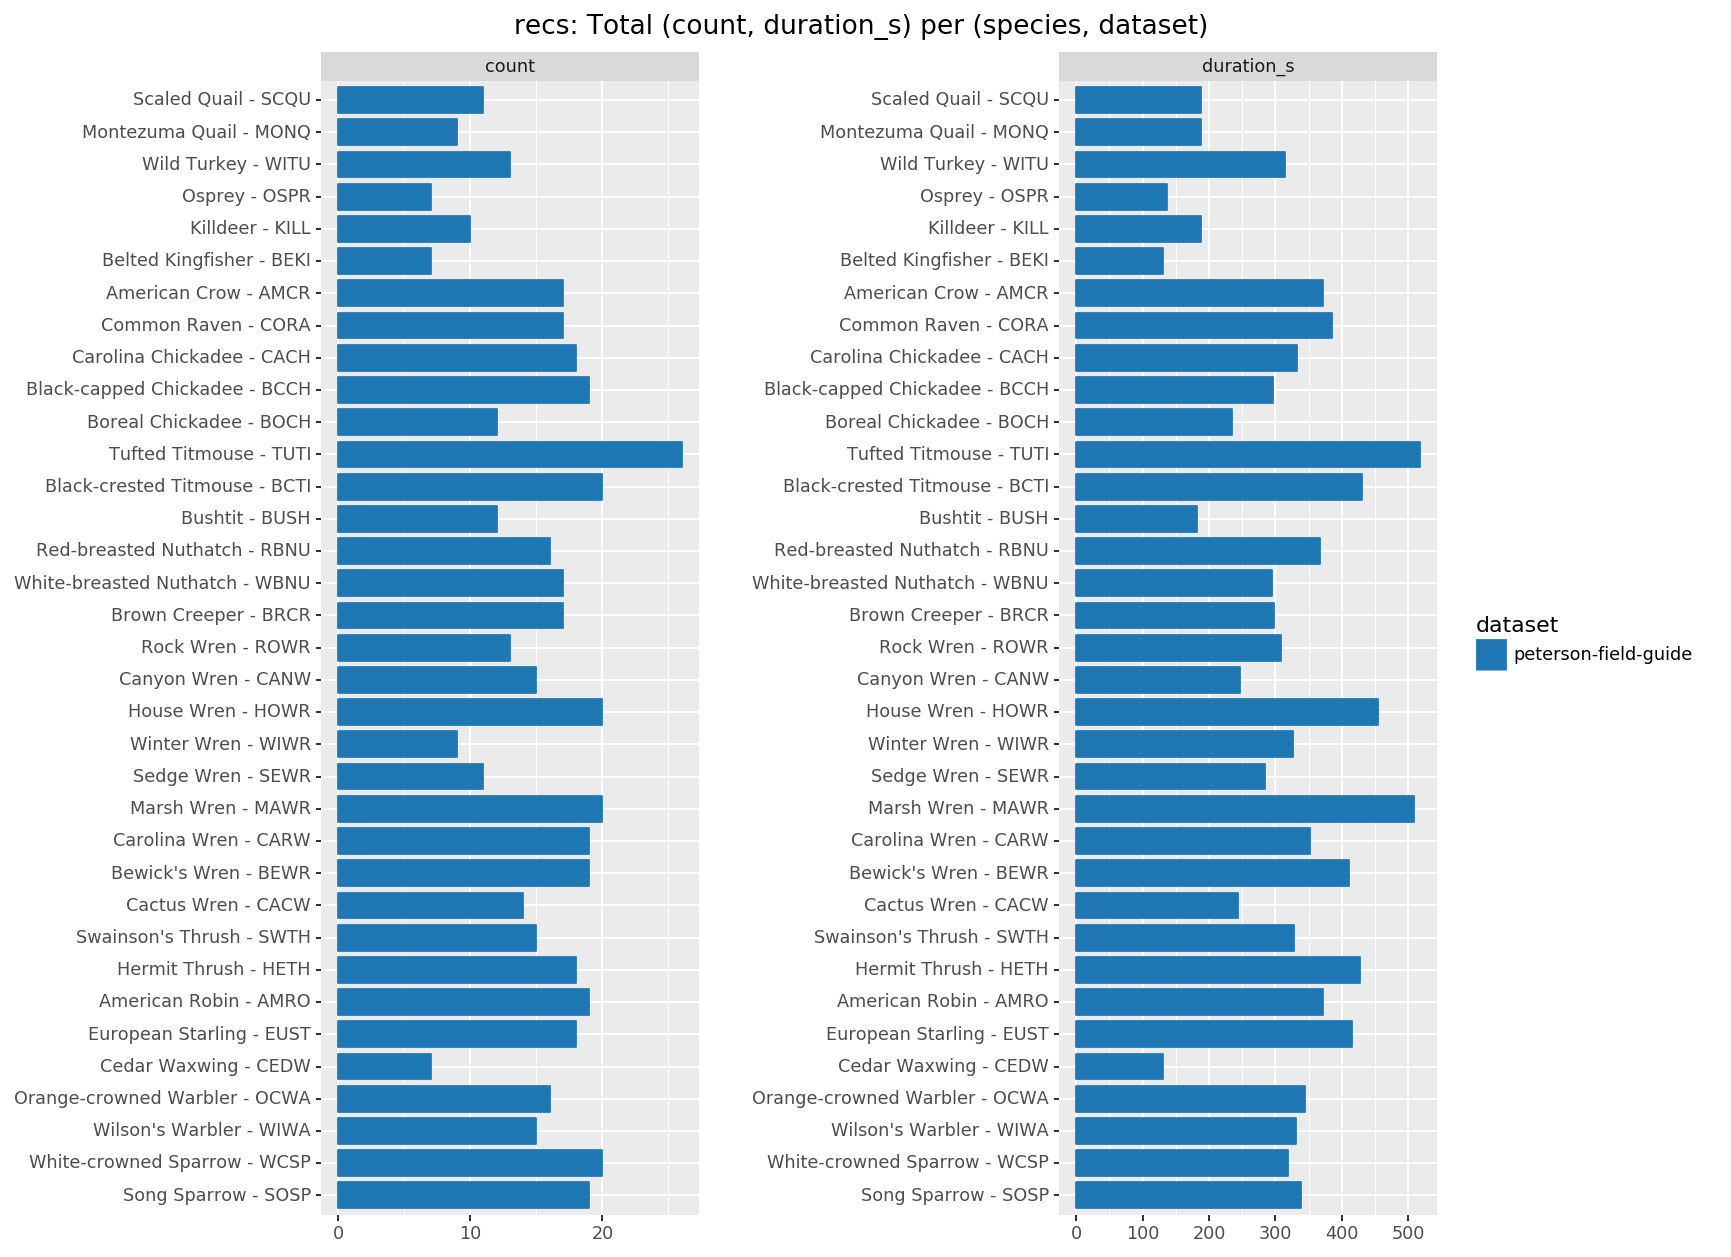

<ggplot: (310854934)>

In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_reverse_cat, 'species')
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=10, aspect_ratio=3/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

In [ ]:
# Load a saved projection model
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[02:40:59.572] Projection.load
  path: /Users/danb/hack/bubo/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Add .feat
recs = projection.transform(recs)

.

[                                                                                          ] | 0% Completed |  0.0s

.

.

.

.

.

.

.

.

.

.

.

..

..

.

.

.

....

.

.

.

.

.

..

..

.

.

.

.

..

.

.

.

..

[                                                                                          ] | 0% Completed |  0.1s

..

.

.

.

.

.

.

.

.

.

.

.

.

..

.

.

.

..

.

..

.

.

.

...

.

..

.

.

.

.

.

.

.

.

.

..

.

.

.

.

.

.

[                                                                                          ] | 0% Completed |  0.2s

..

.

.

.

..

.

.

..

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

...

..

.

.

.

...

.

.

..

.

.

.

.

.

.

.

[##################                                                                        ] | 20% Completed |  0.3s

.

...

.

.

.

.

.

.

..

.

.

.

.

.

.

.

.

.

.

..

.

.

.

.

.

.

.

.

.

..

.

.

.

.

.

.

.

.

.

.

.

.

.

..

.

.

.

[##################                                                                        ] | 20% Completed |  0.4s

.

.

..

...

..

.

.

.

.

.

.

.

.

.

.

...

.

.

.

.

.

.

.

.

.

.

.

.

..

.

.

..

.

.

.

.

.

.

.

.

...

[####################################                                                      ] | 41% Completed |  0.5s

.

.

..

.

..

.

.

.

.

.

.

.

..

.

.

.

.

.

.

.

.

.

..

.

.

..

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

[####################################                                                      ] | 41% Completed |  0.6s

.

.

.

.

.

.

.

.

.

.

.

.

.

.

..

.

.

.

.

.

.

..

..

...

.

..

.

.

.

.

.

..

.

.

.

.

.

.

.

[#####################################################                                     ] | 58% Completed |  0.7s

...

.

.

.

.

.

..

.

..

.

.

.

...

.

.

..

.

.

.

.

.

.

...

.

.

.

.

.

.

.

..

..

.

.

.

.

.

..

.

.

.

[#######################################################                                   ] | 61% Completed |  0.9s.

.

..

..

.

.

.

.

..

.

.

..

.

...

.

.

.

.

..

.

.

.

.

..

..

.

.

.

.

.

.

..

.

.

.

.

.

..

.

[########################################################                                  ] | 62% Completed |  1.0s

.

.

.

.

.

.

.

.

..

..

.

.

.

.

.

...

.

..

.

.

..

.

.

.

..

.

.

.

..

.

.

.

.

..

.

[############################################################################              ] | 84% Completed |  1.1s

.

.

.

.

..

.

.

.

...

.

.

.

.

..

.

.

.

..

.

.

.

.

.

.

.

.

..

..

.

.

.

.

.

.

.

.

.

.

..

.

[################################################################################          ] | 89% Completed |  1.2s

.

[##########################################################################################] | 100% Completed |  1.3s

In [ ]:
# GridSearchCV many models / model params
param_grid = dict(
    classifier=[

        # KNN
        #   - Bad for large k because we only have ~7-26 instances per class
        #   - Bad for small k because KNN
        'cls: knn, n_neighbors: 1',
        'cls: knn, n_neighbors: 3',
        'cls: knn, n_neighbors: 5',
        'cls: knn, n_neighbors: 10',
        # 'cls: knn, n_neighbors: 15',
        'cls: knn, n_neighbors: 25',
        # 'cls: knn, n_neighbors: 50',

        # SVM(RBF)
        #   - [SBF16] Uses these
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1',
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10',  # [SBF16]
        'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100',  # Same as C:10 [why?]
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1000',  # Same as C:10 [why?]

        # RandomForest(entropy)
        #   - [SP14] uses entropy
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 10',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100',
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200',  # [SP14]
        'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400',

        # RandomForest(gini)
        #   - sk uses gini by default
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 10',  # [sk default]
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 50',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 100',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 200',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 400',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 600',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 800',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 1000',

    ]
    # TODO agg_funs
)

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    cv=sk.model_selection.ShuffleSplit(
        # n_splits=1,
        # n_splits=2,
        # n_splits=5,
        # n_splits=10,
        n_splits=20,
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        test_i='i_test',
        test_y='y_test',
        test_classes='estimator.classes_',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
    ),
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # n_jobs=1,  # For %prun
    # n_jobs=8,
    n_jobs=16,
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(verbose=False))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 20 folds for each of 19 candidates, totalling 380 fits


.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s


.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

[Parallel(n_jobs=16)]: Done 380 out of 380 | elapsed:    1.5s finished


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, classifier_type, fold, ...
cv_models = (cv_results_splits_df(cv.cv_results_)
    # .params
    .assign(
        # Slow yaml parsing, compute up front
        params_dict=lambda df: df.apply(axis=1, func=lambda row: {
            'classifier': yaml.safe_load('{%s}' % row.param_classifier),
            # TODO More param_*
        }),
        params=lambda df: (
            df.pop('param_classifier')
            # TODO More param_*
        ),
    )
    # Dims from params
    .assign(
        classifier_type=lambda df: df.params_dict.str['classifier'].apply(lambda x: (
            '%s-%s' % (x['cls'], x['criterion']) if x['cls'] == 'rf' else
            x['cls']
        )),
    )
    # .eval
    .assign(test_evals=lambda df: np.vectorize(SearchEvals)(
        i=df.pop('test_i'),
        y=df.pop('test_y'),
        classes=df.pop('test_classes'),
        y_scores=df.pop('test_predict_proba'),
    ))
    # Reorder
    .pipe(df_reorder_cols, first=[
        'model_id', 'params', 'params_dict', 'classifier_type',
    ])
)
display(
    df_summary(cv_models).T,
    cv_models[:5],
)

min                                25%                                                                      50%                                                                     75%                                                                       max
                dtype   sizeof   len count nunique mean std                                                                                                                                                                                                                                                                                                  
model_id        object  41930    380 380   380.0   NaN  NaN  cls: knn, n_neighbors: 10; fold: 0  cls: knn, n_neighbors: 5; fold: 4  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 17  cls: rf, random_state: 0, criterion: gini, n_estimators: 600; fold: 12  cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1; fold: 9
params          object  38320    380 380   19.0    NaN  NaN            cls: knn, n_neighbors: 1           cls: knn, n_neighbors: 5             cls: rf, random_state: 0, criterion: gini, n_estimators: 100            cls: rf, random_state: 0, criterion: gini, n_estimators: 600         cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100
params_dict     object  91200    380 380   NaN     NaN  NaN                                 NaN                                NaN                                                                      NaN                                                                     NaN                                                                       NaN
classifier_type object  20880    380 380   4.0     NaN  NaN                                 knn                                knn                                                                  rf-gini                                                                 rf-gini                                                                       svm
fold            int64   10564    380 380   20.0    NaN  NaN                                   0                                  4                                                                        9                                                                      14                                                                        19
train_score     float64 9120     380 380   3.0     NaN  NaN                                  -3                                 -1                                                                       -1                                                                      -1                                                                        -1
test_score      float64 9120     380 380   7.0     NaN  NaN                                 -35                                 -5                                                                       -3                                                                      -3                                                                        -2
test_evals      object  12812460 380 380   NaN     NaN  NaN                                 NaN                                NaN                                                                      NaN                                                                     NaN                                                                       NaN

model_id                    params                                       params_dict classifier_type  fold  train_score  test_score                                                              test_evals
0  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     0         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
1  cls: knn, n_neighbors: 1; fold: 1  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     1         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
2  cls: knn, n_neighbors: 1; fold: 2  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     2         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
3  cls: knn, n_neighbors: 1; fold: 3  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     3         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
4  cls: knn, n_neighbors: 1; fold: 4  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     4         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])

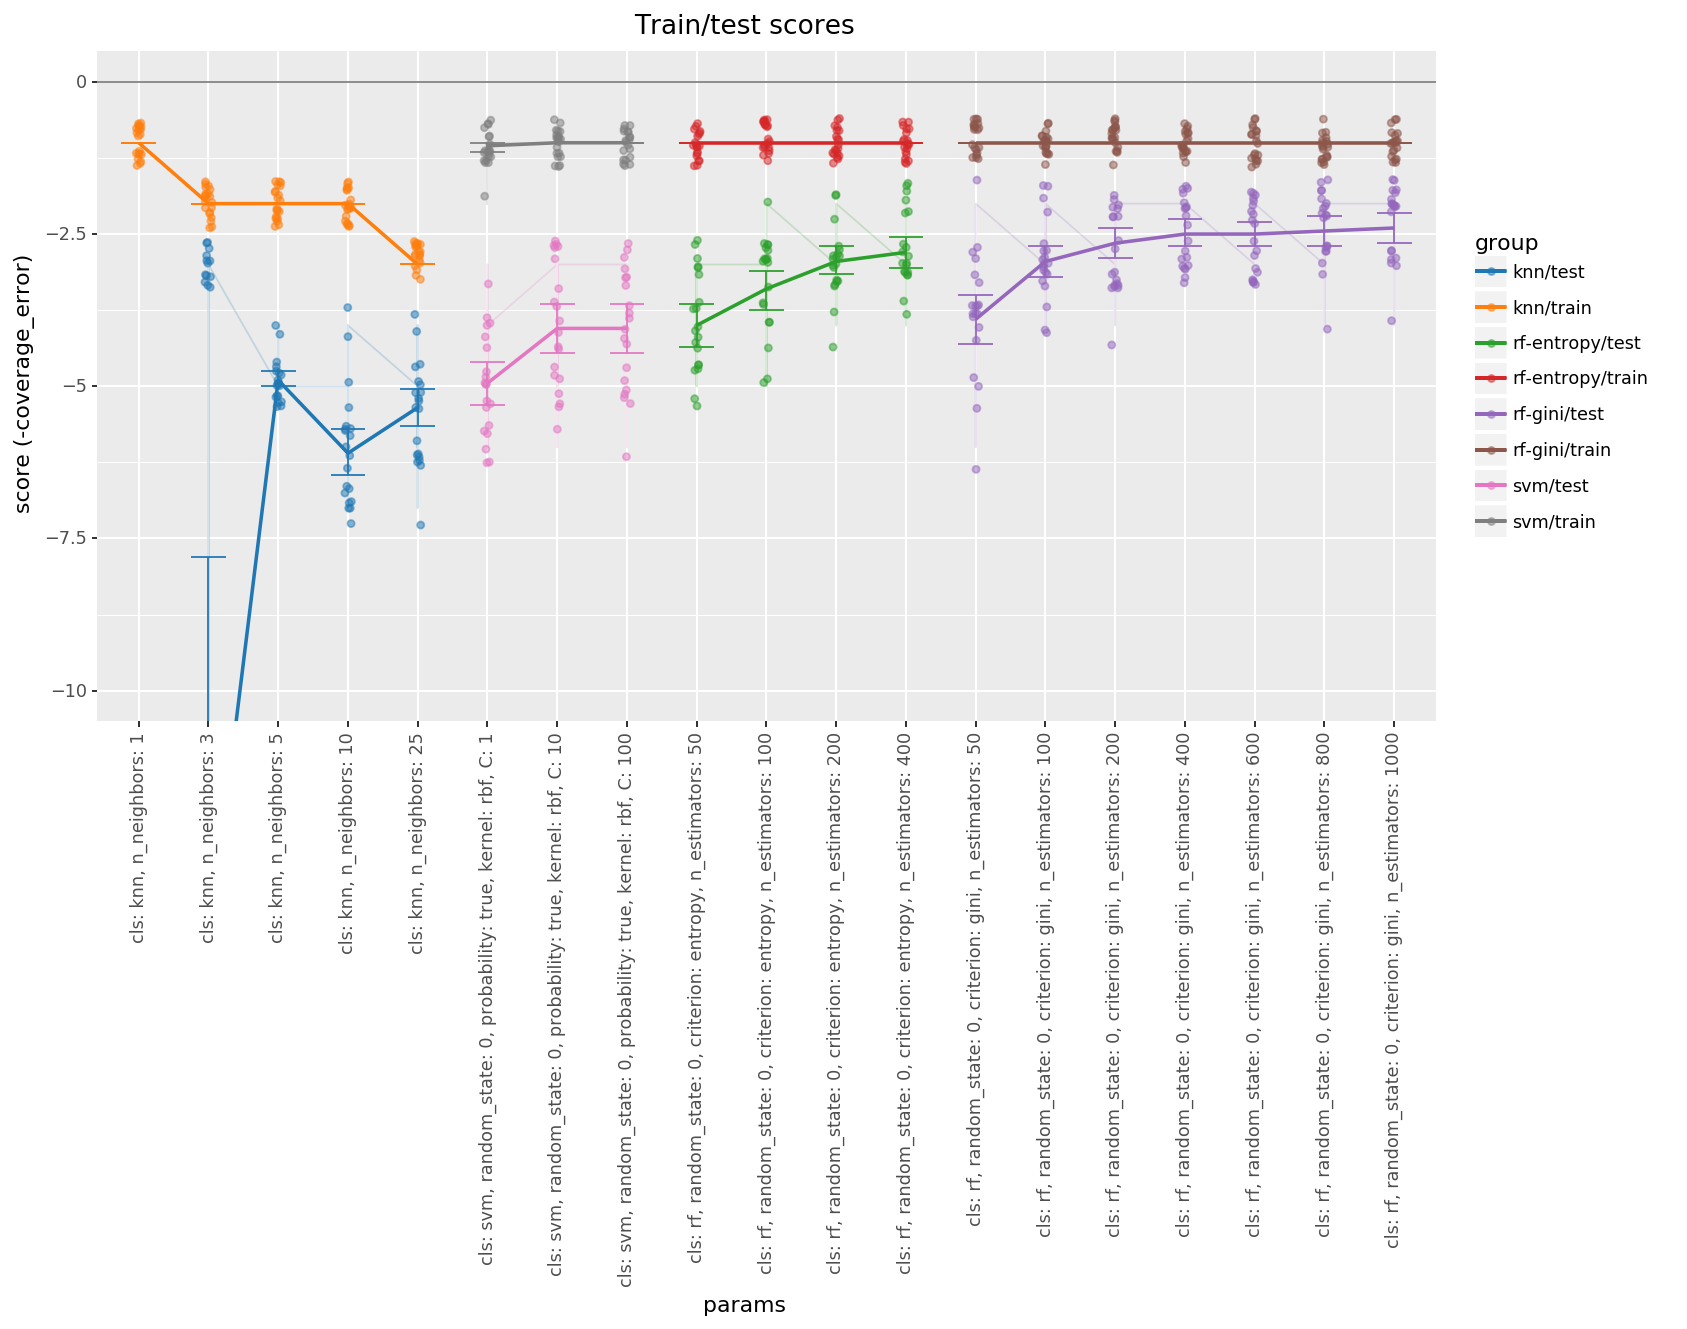

<ggplot: (314976043)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(lambda df: pd.melt(
        df,
        id_vars=['classifier_type', 'params', 'fold'],
        value_vars=['train_score', 'test_score'],
        var_name='split',
        value_name='score'),
    )
    .assign(
        split=lambda df: df.split.str.replace('_score', ''),
        group=lambda df: df.apply(axis=1, func=lambda row: row.classifier_type + '/' + row.split),
    )
    .pipe(df_ordered_cat, params=lambda df: param_grid['classifier'])
    .pipe(ggplot, aes(x='params', y='score', color='group'))
    + geom_hline(yintercept=0, color='grey')
    + geom_jitter(alpha=.5, width=.05)
    + geom_line(aes(group='group + str(fold)'), alpha=.2)
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='line', size=1)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(axis_text_x=element_text(angle=90, hjust=.5))
    + theme_figsize(width=12, aspect_ratio=1/2)
    + coord_cartesian(ylim=(-10, 0))
    + ylab('score (-coverage_error)')
    + ggtitle('Train/test scores')
)

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(param_grid['classifier']))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/19]
  fold[*/20]


In [ ]:
# TODO TODO Bubble down
#   - Subset: all models
#   - Grain: models
#   - Dims: model_id, params, classifier_type, fold, y_true
#   - Metrics: train_score, test_score, test_evals
(cv_models
    [:5]
)

model_id                    params                                       params_dict classifier_type  fold  train_score  test_score                                                              test_evals
0  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     0         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
1  cls: knn, n_neighbors: 1; fold: 1  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     1         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
2  cls: knn, n_neighbors: 1; fold: 2  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     2         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
3  cls: knn, n_neighbors: 1; fold: 3  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     3         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])
4  cls: knn, n_neighbors: 1; fold: 4  cls: knn, n_neighbors: 1  {'classifier': {'cls': 'knn', 'n_neighbors': 1}}             knn     4         -1.0       -35.0  SearchEvals(i[(107,)], y[(107,)], classes[(35,)], y_scores[(107, 35)])

In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            classifier_type=row.classifier_type,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
)
display(
    df_summary(coverage_errors_all_all).T,
    coverage_errors_all_all[:10],
)

  0%|                                                                                          | 0/380 [00:00<?, ?it/s]

  1%|▋                                                                                 | 3/380 [00:00<00:15, 24.21it/s]

  2%|█▎                                                                                | 6/380 [00:00<00:14, 25.17it/s]

  2%|█▉                                                                                | 9/380 [00:00<00:14, 25.81it/s]

  3%|██▌                                                                              | 12/380 [00:00<00:14, 25.74it/s]

  4%|███▏                                                                             | 15/380 [00:00<00:14, 26.07it/s]

  5%|███▊                                                                             | 18/380 [00:00<00:13, 26.26it/s]

  6%|████▍                                                                            | 21/380 [00:00<00:13, 26.48it/s]

  6%|█████                                                                            | 24/380 [00:00<00:13, 26.55it/s]

  7%|█████▊                                                                           | 27/380 [00:01<00:13, 26.46it/s]

  8%|██████▍                                                                          | 30/380 [00:01<00:13, 26.36it/s]

  9%|███████                                                                          | 33/380 [00:01<00:13, 26.36it/s]

  9%|███████▋                                                                         | 36/380 [00:01<00:13, 26.40it/s]

 10%|████████▎                                                                        | 39/380 [00:01<00:12, 26.44it/s]

 11%|████████▉                                                                        | 42/380 [00:01<00:12, 26.42it/s]

 12%|█████████▌                                                                       | 45/380 [00:01<00:12, 26.53it/s]

 13%|██████████▏                                                                      | 48/380 [00:01<00:12, 26.49it/s]

 13%|██████████▊                                                                      | 51/380 [00:01<00:12, 26.49it/s]

 14%|███████████▌                                                                     | 54/380 [00:02<00:12, 26.50it/s]

 15%|████████████▏                                                                    | 57/380 [00:02<00:12, 26.56it/s]

 16%|████████████▊                                                                    | 60/380 [00:02<00:12, 26.43it/s]

 17%|█████████████▍                                                                   | 63/380 [00:02<00:12, 26.17it/s]

 17%|██████████████                                                                   | 66/380 [00:02<00:12, 26.16it/s]

 18%|██████████████▋                                                                  | 69/380 [00:02<00:11, 26.14it/s]

 19%|███████████████▎                                                                 | 72/380 [00:02<00:11, 26.18it/s]

 20%|███████████████▉                                                                 | 75/380 [00:02<00:11, 26.22it/s]

 21%|████████████████▋                                                                | 78/380 [00:02<00:11, 26.18it/s]

 21%|█████████████████▎                                                               | 81/380 [00:03<00:11, 26.15it/s]

 22%|█████████████████▉                                                               | 84/380 [00:03<00:11, 26.14it/s]

 23%|██████████████████▌                                                              | 87/380 [00:03<00:11, 26.19it/s]

 24%|███████████████████▏                                                             | 90/380 [00:03<00:11, 26.22it/s]

 24%|███████████████████▊                                                             | 93/380 [00:03<00:10, 26.22it/s]

 25%|████████████████████▍                                                            | 96/380 [00:03<00:10, 26.29it/s]

 26%|█████████████████████                                                            | 99/380 [00:03<00:10, 26.25it/s]

 27%|█████████████████████▍                                                          | 102/380 [00:03<00:10, 26.28it/s]

 28%|██████████████████████                                                          | 105/380 [00:04<00:10, 26.24it/s]

 28%|██████████████████████▋                                                         | 108/380 [00:04<00:10, 26.26it/s]

 29%|███████████████████████▎                                                        | 111/380 [00:04<00:10, 26.26it/s]

 30%|████████████████████████                                                        | 114/380 [00:04<00:10, 26.28it/s]

 31%|████████████████████████▋                                                       | 117/380 [00:04<00:10, 26.27it/s]

 32%|█████████████████████████▎                                                      | 120/380 [00:04<00:09, 26.28it/s]

 32%|█████████████████████████▉                                                      | 123/380 [00:04<00:09, 26.31it/s]

 33%|██████████████████████████▌                                                     | 126/380 [00:04<00:09, 26.32it/s]

 34%|███████████████████████████▏                                                    | 129/380 [00:04<00:09, 26.31it/s]

 35%|███████████████████████████▊                                                    | 132/380 [00:05<00:09, 26.32it/s]

 36%|████████████████████████████▍                                                   | 135/380 [00:05<00:09, 26.32it/s]

 36%|█████████████████████████████                                                   | 138/380 [00:05<00:09, 26.35it/s]

 37%|█████████████████████████████▋                                                  | 141/380 [00:05<00:09, 26.37it/s]

 38%|██████████████████████████████▎                                                 | 144/380 [00:05<00:08, 26.40it/s]

 39%|██████████████████████████████▉                                                 | 147/380 [00:05<00:08, 26.45it/s]

 39%|███████████████████████████████▌                                                | 150/380 [00:05<00:08, 26.49it/s]

 40%|████████████████████████████████▏                                               | 153/380 [00:05<00:08, 26.49it/s]

 41%|████████████████████████████████▊                                               | 156/380 [00:05<00:08, 26.53it/s]

 42%|█████████████████████████████████▍                                              | 159/380 [00:05<00:08, 26.57it/s]

 43%|██████████████████████████████████                                              | 162/380 [00:06<00:08, 26.58it/s]

 43%|██████████████████████████████████▋                                             | 165/380 [00:06<00:08, 26.60it/s]

 44%|███████████████████████████████████▎                                            | 168/380 [00:06<00:07, 26.60it/s]

 45%|████████████████████████████████████                                            | 171/380 [00:06<00:07, 26.59it/s]

 46%|████████████████████████████████████▋                                           | 174/380 [00:06<00:07, 26.59it/s]

 47%|█████████████████████████████████████▎                                          | 177/380 [00:06<00:07, 26.61it/s]

 47%|█████████████████████████████████████▉                                          | 180/380 [00:06<00:07, 26.64it/s]

 48%|██████████████████████████████████████▌                                         | 183/380 [00:06<00:07, 26.65it/s]

 49%|███████████████████████████████████████▏                                        | 186/380 [00:06<00:07, 26.65it/s]

 50%|███████████████████████████████████████▊                                        | 189/380 [00:07<00:07, 26.66it/s]

 51%|████████████████████████████████████████▍                                       | 192/380 [00:07<00:07, 26.63it/s]

 51%|█████████████████████████████████████████                                       | 195/380 [00:07<00:06, 26.65it/s]

 52%|█████████████████████████████████████████▋                                      | 198/380 [00:07<00:06, 26.62it/s]

 53%|██████████████████████████████████████████▎                                     | 201/380 [00:07<00:06, 26.59it/s]

 54%|██████████████████████████████████████████▉                                     | 204/380 [00:07<00:06, 26.58it/s]

 54%|███████████████████████████████████████████▌                                    | 207/380 [00:07<00:06, 26.60it/s]

 55%|████████████████████████████████████████████▏                                   | 210/380 [00:07<00:06, 26.60it/s]

 56%|████████████████████████████████████████████▊                                   | 213/380 [00:08<00:06, 26.61it/s]

 57%|█████████████████████████████████████████████▍                                  | 216/380 [00:08<00:06, 26.62it/s]

 58%|██████████████████████████████████████████████                                  | 219/380 [00:08<00:06, 26.63it/s]

 58%|██████████████████████████████████████████████▋                                 | 222/380 [00:08<00:05, 26.64it/s]

 59%|███████████████████████████████████████████████▎                                | 225/380 [00:08<00:05, 26.66it/s]

 60%|████████████████████████████████████████████████                                | 228/380 [00:08<00:05, 26.66it/s]

 61%|████████████████████████████████████████████████▋                               | 231/380 [00:08<00:05, 26.64it/s]

 62%|█████████████████████████████████████████████████▎                              | 234/380 [00:08<00:05, 26.64it/s]

 62%|█████████████████████████████████████████████████▉                              | 237/380 [00:08<00:05, 26.64it/s]

 63%|██████████████████████████████████████████████████▌                             | 240/380 [00:09<00:05, 26.62it/s]

 64%|███████████████████████████████████████████████████▏                            | 243/380 [00:09<00:05, 26.61it/s]

 65%|███████████████████████████████████████████████████▊                            | 246/380 [00:09<00:05, 26.62it/s]

 66%|████████████████████████████████████████████████████▍                           | 249/380 [00:09<00:04, 26.63it/s]

 66%|█████████████████████████████████████████████████████                           | 252/380 [00:09<00:04, 26.62it/s]

 67%|█████████████████████████████████████████████████████▋                          | 255/380 [00:09<00:04, 26.59it/s]

 68%|██████████████████████████████████████████████████████▎                         | 258/380 [00:09<00:04, 26.58it/s]

 69%|██████████████████████████████████████████████████████▉                         | 261/380 [00:09<00:04, 26.56it/s]

 69%|███████████████████████████████████████████████████████▌                        | 264/380 [00:09<00:04, 26.54it/s]

 70%|████████████████████████████████████████████████████████▏                       | 267/380 [00:10<00:04, 26.51it/s]

 71%|████████████████████████████████████████████████████████▊                       | 270/380 [00:10<00:04, 26.52it/s]

 72%|█████████████████████████████████████████████████████████▍                      | 273/380 [00:10<00:04, 26.54it/s]

 73%|██████████████████████████████████████████████████████████                      | 276/380 [00:10<00:03, 26.53it/s]

 73%|██████████████████████████████████████████████████████████▋                     | 279/380 [00:10<00:03, 26.54it/s]

 74%|███████████████████████████████████████████████████████████▎                    | 282/380 [00:10<00:03, 26.52it/s]

 75%|████████████████████████████████████████████████████████████                    | 285/380 [00:10<00:03, 26.51it/s]

 76%|████████████████████████████████████████████████████████████▋                   | 288/380 [00:10<00:03, 26.49it/s]

 77%|█████████████████████████████████████████████████████████████▎                  | 291/380 [00:10<00:03, 26.51it/s]

 77%|█████████████████████████████████████████████████████████████▉                  | 294/380 [00:11<00:03, 26.50it/s]

 78%|██████████████████████████████████████████████████████████████▌                 | 297/380 [00:11<00:03, 26.50it/s]

 79%|███████████████████████████████████████████████████████████████▏                | 300/380 [00:11<00:03, 26.50it/s]

 80%|███████████████████████████████████████████████████████████████▊                | 303/380 [00:11<00:02, 26.50it/s]

 81%|████████████████████████████████████████████████████████████████▍               | 306/380 [00:11<00:02, 26.49it/s]

 81%|█████████████████████████████████████████████████████████████████               | 309/380 [00:11<00:02, 26.50it/s]

 82%|█████████████████████████████████████████████████████████████████▋              | 312/380 [00:11<00:02, 26.51it/s]

 83%|██████████████████████████████████████████████████████████████████▎             | 315/380 [00:11<00:02, 26.52it/s]

 84%|██████████████████████████████████████████████████████████████████▉             | 318/380 [00:11<00:02, 26.52it/s]

 84%|███████████████████████████████████████████████████████████████████▌            | 321/380 [00:12<00:02, 26.53it/s]

 85%|████████████████████████████████████████████████████████████████████▏           | 324/380 [00:12<00:02, 26.54it/s]

 86%|████████████████████████████████████████████████████████████████████▊           | 327/380 [00:12<00:01, 26.54it/s]

 87%|█████████████████████████████████████████████████████████████████████▍          | 330/380 [00:12<00:01, 26.53it/s]

 88%|██████████████████████████████████████████████████████████████████████          | 333/380 [00:12<00:01, 26.51it/s]

 88%|██████████████████████████████████████████████████████████████████████▋         | 336/380 [00:12<00:01, 26.53it/s]

 89%|███████████████████████████████████████████████████████████████████████▎        | 339/380 [00:12<00:01, 26.54it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 342/380 [00:12<00:01, 26.54it/s]

 91%|████████████████████████████████████████████████████████████████████████▋       | 345/380 [00:12<00:01, 26.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████▎      | 348/380 [00:13<00:01, 26.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 351/380 [00:13<00:01, 26.57it/s]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 354/380 [00:13<00:00, 26.56it/s]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 357/380 [00:13<00:00, 26.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 360/380 [00:13<00:00, 26.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 363/380 [00:13<00:00, 26.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████   | 366/380 [00:13<00:00, 26.57it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 369/380 [00:13<00:00, 26.57it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 372/380 [00:13<00:00, 26.58it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 375/380 [00:14<00:00, 26.59it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 378/380 [00:14<00:00, 26.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:14<00:00, 26.60it/s]

min                                25%                                                                      50%                                                                     75%                                                                       max
                dtype   sizeof   len   count nunique mean std                                                                                                                                                                                                                                                                                                  
model_id        object  4608490  40660 40660 380     NaN  NaN  cls: knn, n_neighbors: 10; fold: 0  cls: knn, n_neighbors: 5; fold: 4  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 17  cls: rf, random_state: 0, criterion: gini, n_estimators: 600; fold: 12  cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1; fold: 9
params          object  12694480 40660 40660 19      NaN  NaN            cls: knn, n_neighbors: 1           cls: knn, n_neighbors: 5             cls: rf, random_state: 0, criterion: gini, n_estimators: 100            cls: rf, random_state: 0, criterion: gini, n_estimators: 600         cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100
classifier_type object  2246144  40660 40660 4       NaN  NaN                                 knn                                knn                                                                  rf-gini                                                                 rf-gini                                                                       svm
fold            int64   1130348  40660 40660 20      NaN  NaN                                   0                                  4                                                                        9                                                                      14                                                                        19
i               int64   1138404  40660 40660 529     NaN  NaN                                   0                                134                                                                      267                                                                     406                                                                       534
y_true          object  3456100  40660 40660 35      NaN  NaN                                AMCR                               BRCR                                                                     HETH                                                                    SEWR                                                                      WIWR
coverage_error  float64 975840   40660 40660 35      NaN  NaN                                   1                                  1                                                                        4                                                                      11                                                                        35

model_id                    params classifier_type  fold    i y_true  coverage_error
0  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  172   BCTI            35.0
1  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  464   CEDW            35.0
2  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  196   BUSH            35.0
3  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  414   HETH            35.0
4  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  531   SOSP            35.0
5  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  210   RBNU            35.0
6  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  485   WIWA            35.0
7  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  236   BRCR            35.0
8  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  419   HETH             1.0
9  cls: knn, n_neighbors: 1; fold: 0  cls: knn, n_neighbors: 1             knn     0  162   TUTI            35.0

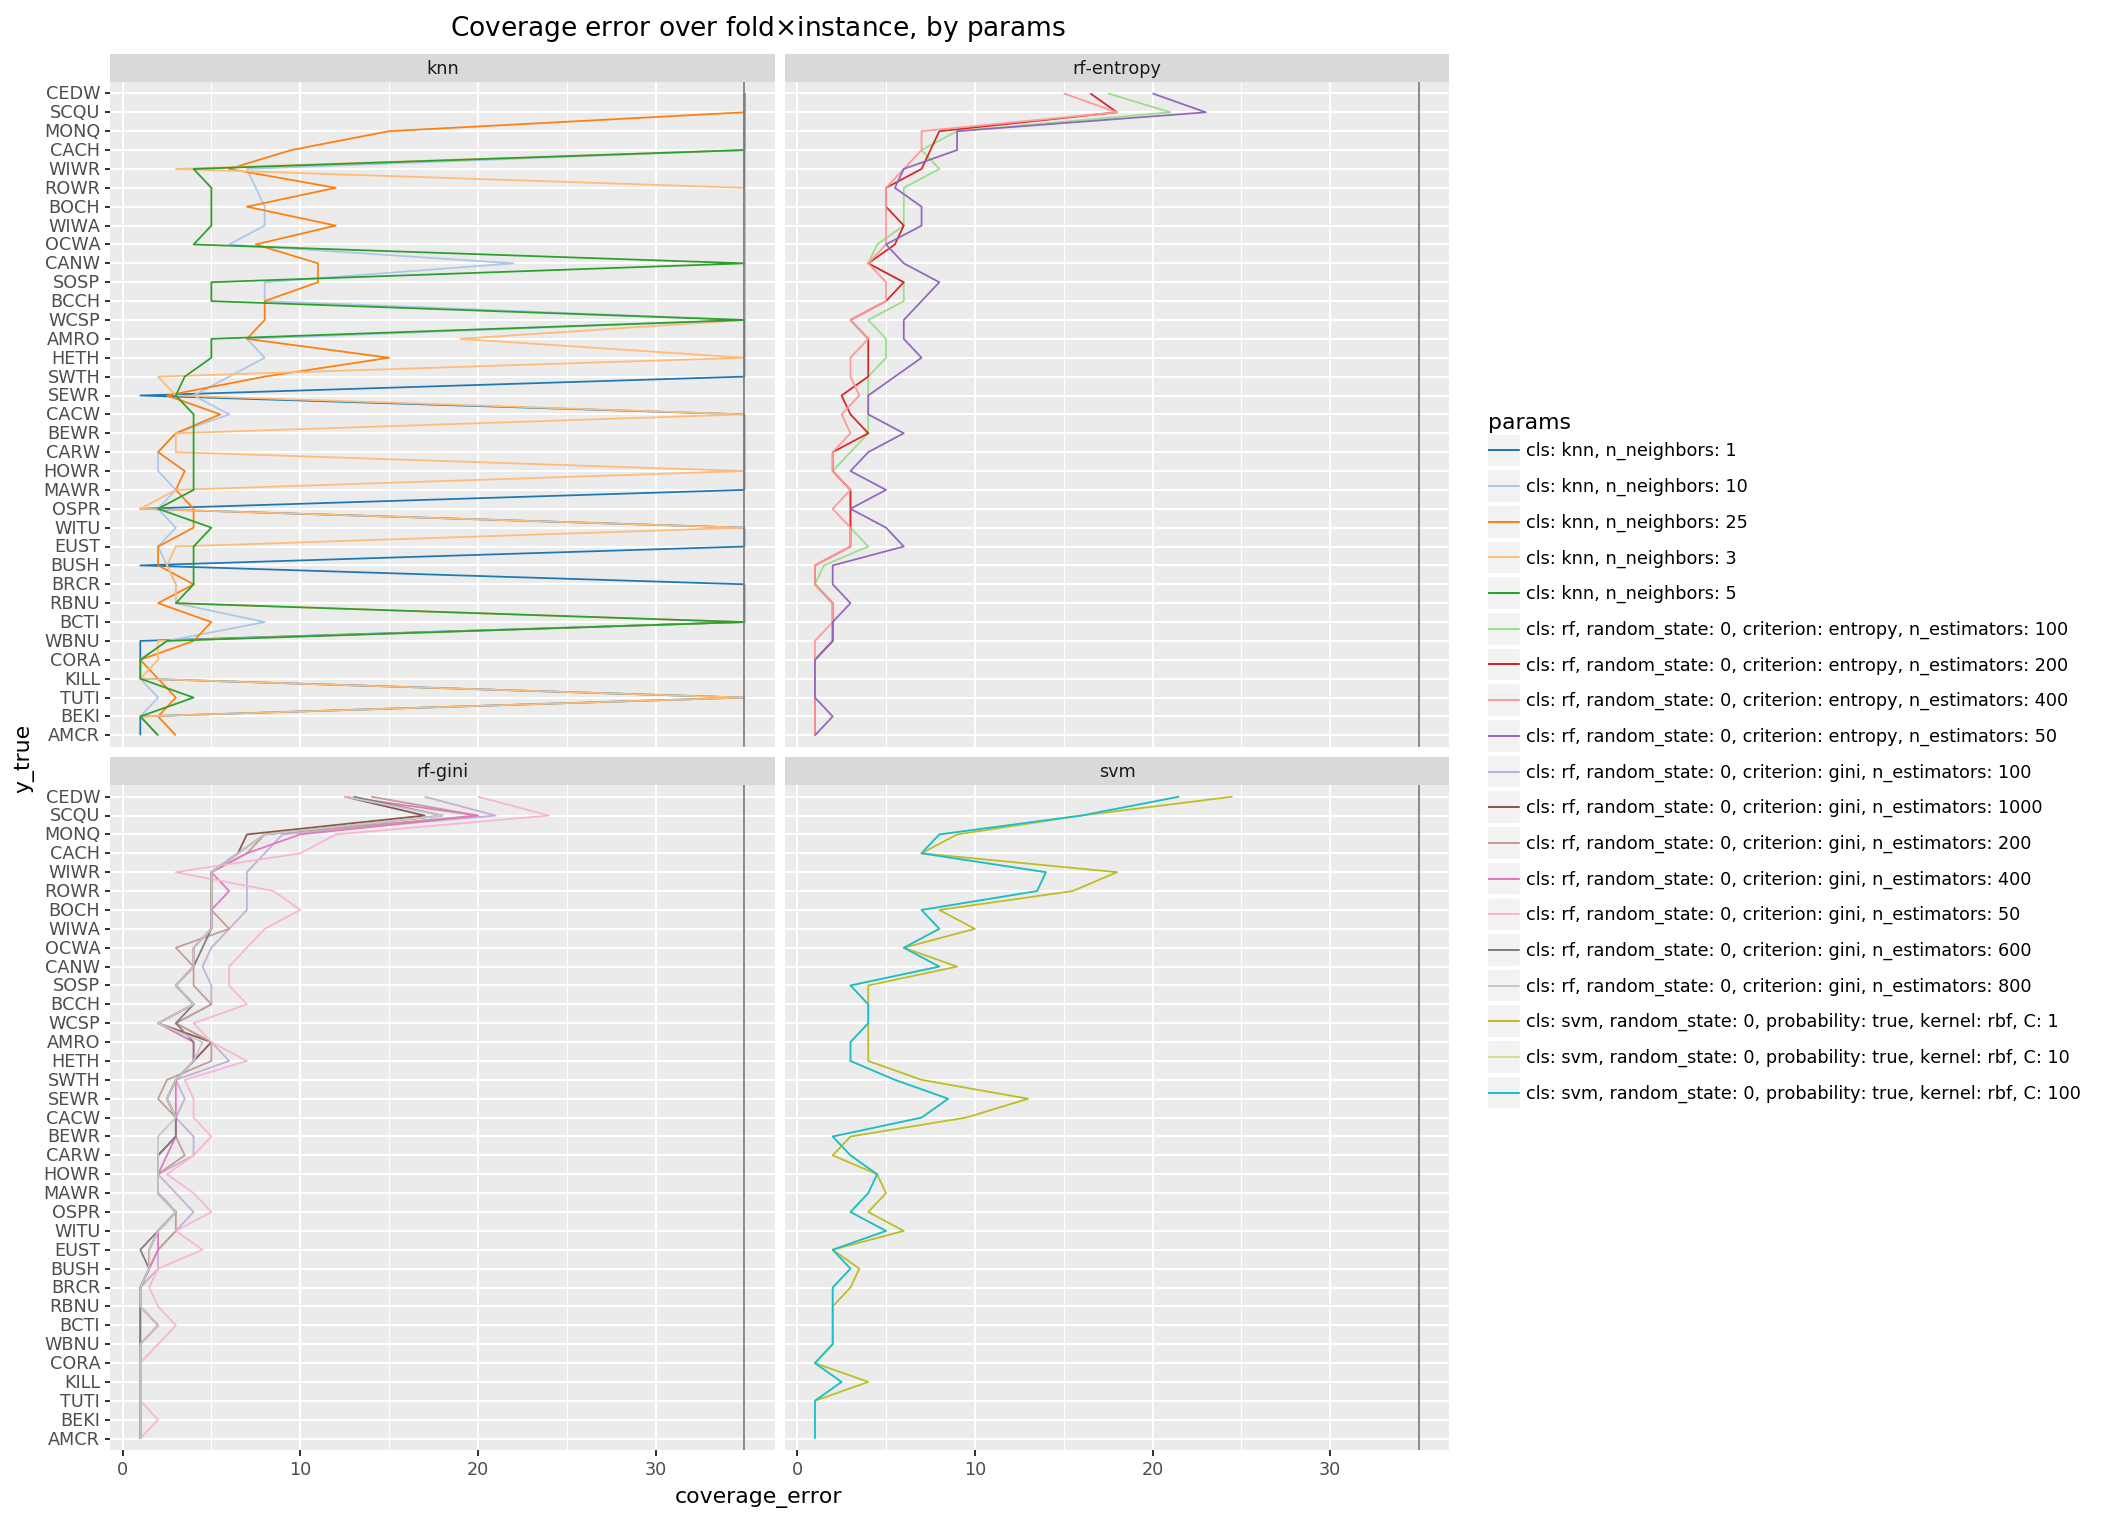

<ggplot: (310855095)>

In [ ]:
# Facet by classifier_type, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # Sort species by median(coverage_error) (across all models)
    .pipe(df_ordered_cat, y_true=lambda df: (
        df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
    ))
    .pipe(ggplot, aes(x='y_true', y='coverage_error', color='params'))
    + facet_wrap('classifier_type')
    + geom_line(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip()
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme_figsize('square')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

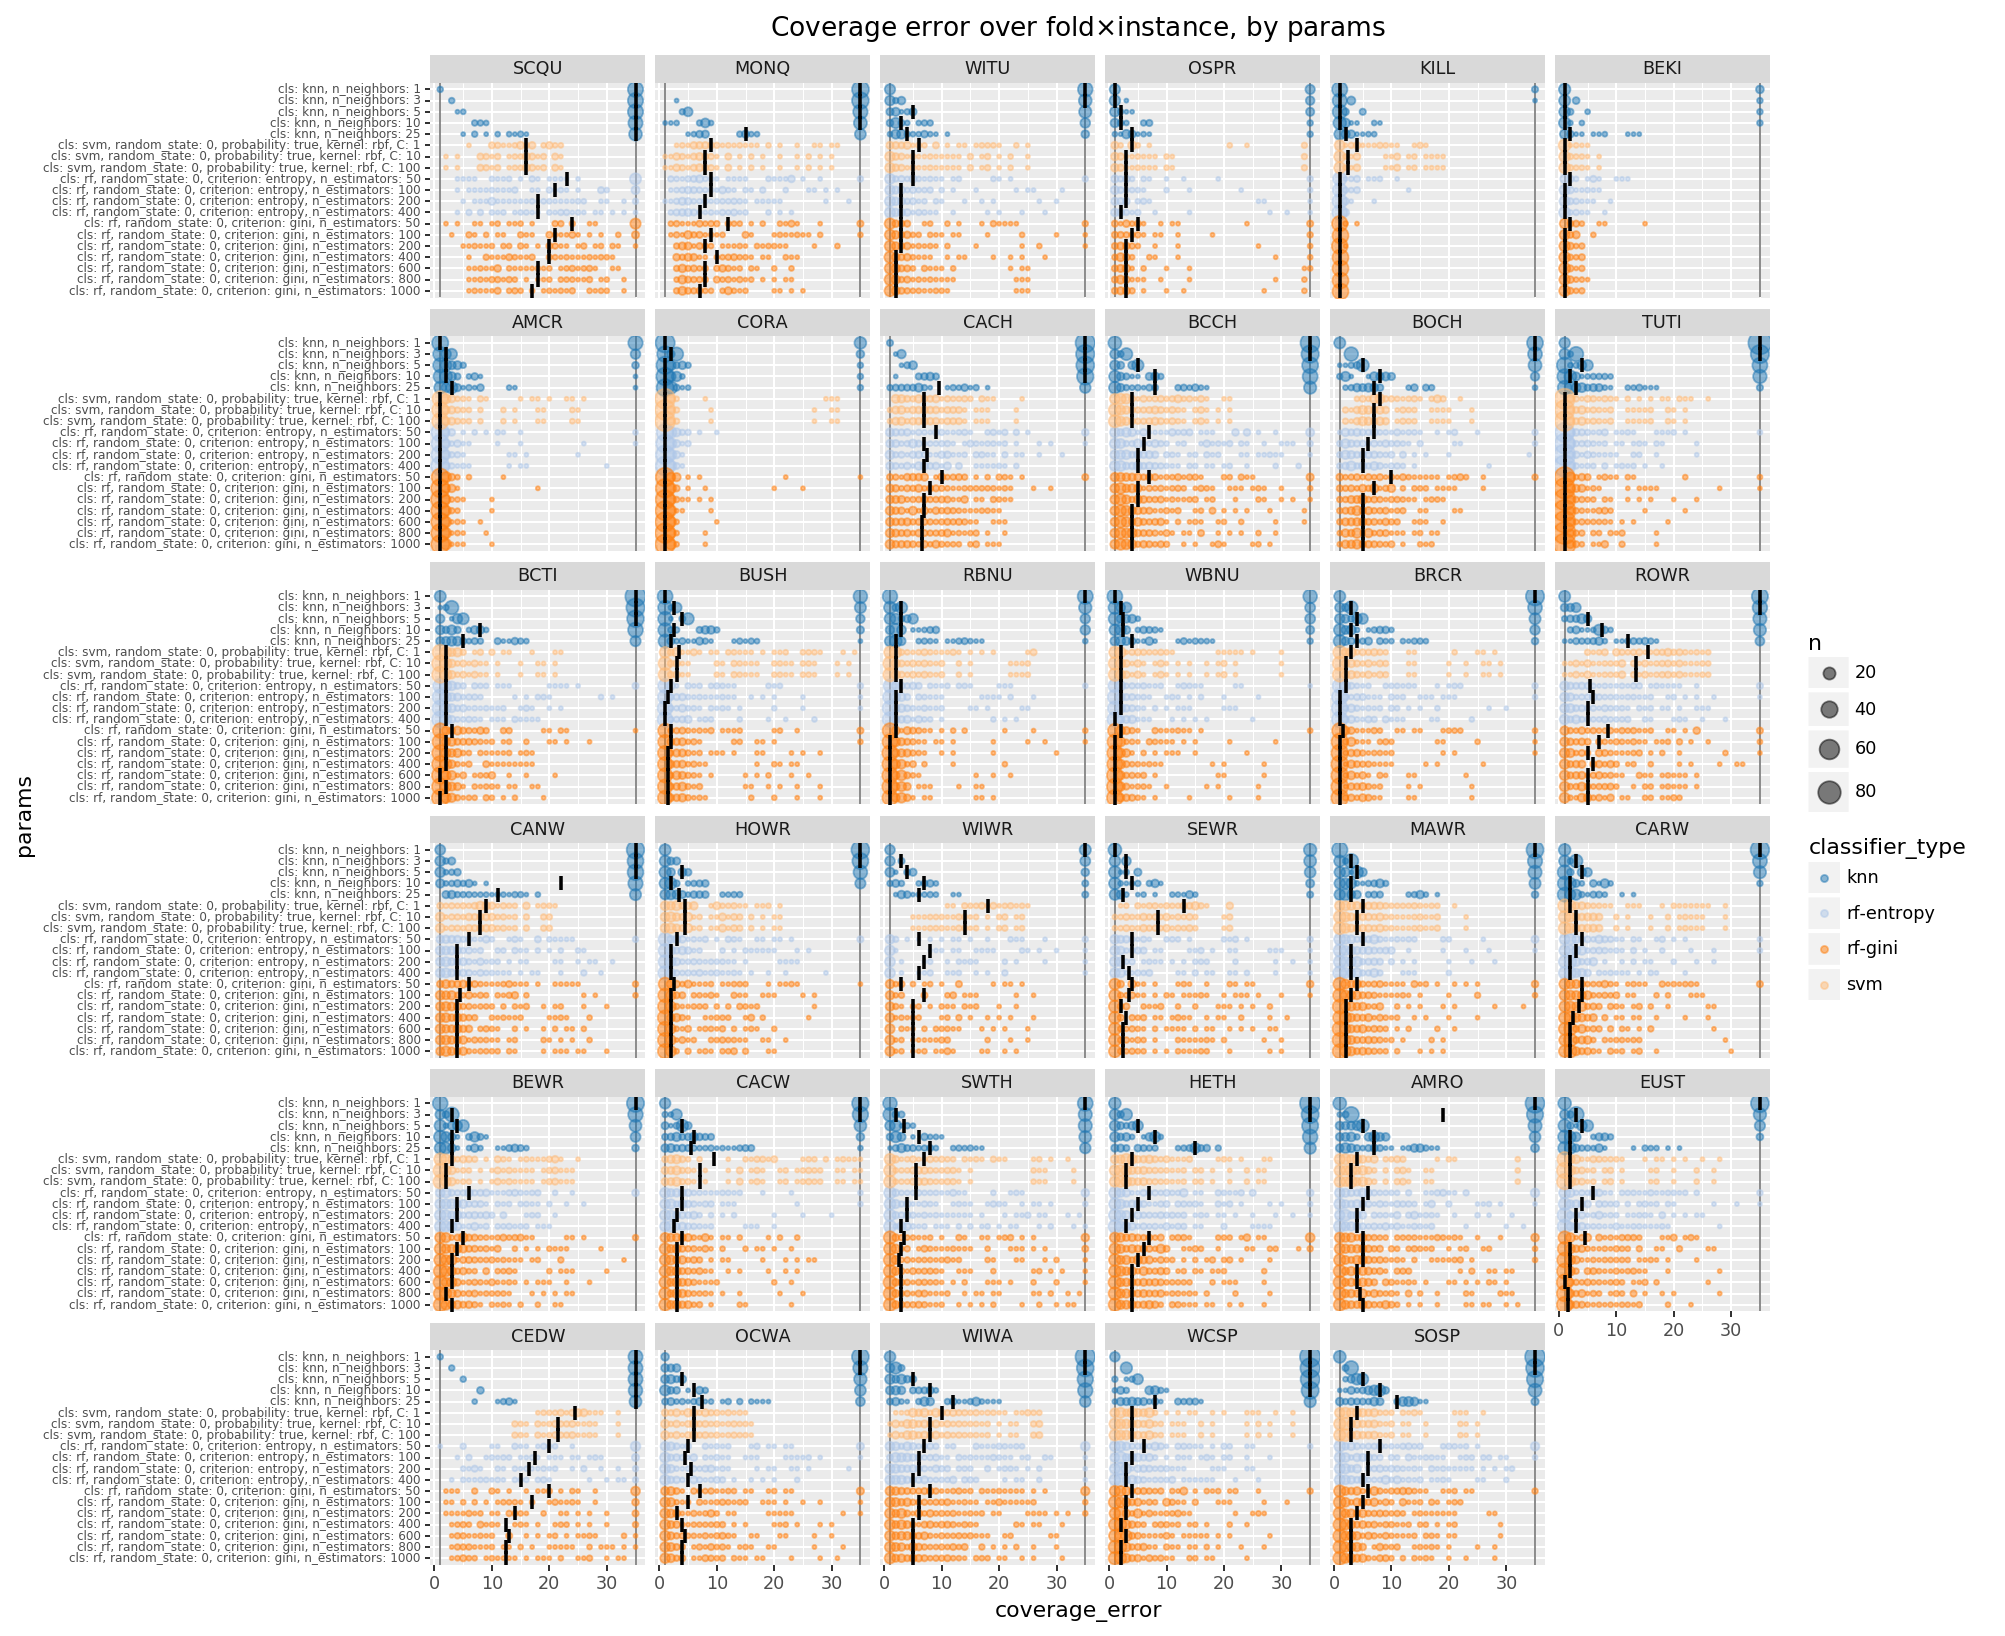

<ggplot: (-9223372036543916449)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # .sample(200, random_state=0)  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_ordered_cat, params=lambda df: reversed(param_grid['classifier']))
    .pipe(ggplot, aes(x='params', y='coverage_error', color='classifier_type'))
    + facet_wrap('y_true')
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')

    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))

    # Violin (slow, no overplot)
    # + geom_violin()

    # Boxplot (very slow, no overplot)
    # + geom_boxplot()

    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), alpha=.5)
    + scale_size_area()
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='black', shape='|', size=3, stroke=1)

    + coord_flip()
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme(axis_text_y=element_text(size=6))
    + theme_figsize('square')  # Faster
    # + theme_figsize('half')
    # + theme_figsize('full')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

# Model diagnostics: one model, all folds

In [ ]:
params_i = 18
params = param_grid['classifier'][params_i]
print("param_grid['classifier']:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_grid['classifier'])))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(param_grid['classifier']), params))
print('  fold[*/%s]' % cv.cv.n_splits)

param_grid['classifier']:
  0: 'cls: knn, n_neighbors: 1'
  1: 'cls: knn, n_neighbors: 3'
  2: 'cls: knn, n_neighbors: 5'
  3: 'cls: knn, n_neighbors: 10'
  4: 'cls: knn, n_neighbors: 25'
  5: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1'
  6: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10'
  7: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100'
  8: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50'
  9: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100'
  10: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200'
  11: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400'
  12: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 50'
  13: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 100'
  14: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 200'
  15: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 400'
  16: 'cls: rf, random_state: 0, cri

In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:10],
)

min                                                                      25%                                                                      50%                                                                     75%                                                                     max
                dtype   sizeof len  count nunique mean std                                                                                                                                                                                                                                                                                                                                                                          
model_id        object  286546 2140 2140  20      NaN  NaN  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 12  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 17  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 4  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 9
params          object  766120 2140 2140  1       NaN  NaN           cls: rf, random_state: 0, criterion: gini, n_estimators: 1000            cls: rf, random_state: 0, criterion: gini, n_estimators: 1000            cls: rf, random_state: 0, criterion: gini, n_estimators: 1000           cls: rf, random_state: 0, criterion: gini, n_estimators: 1000           cls: rf, random_state: 0, criterion: gini, n_estimators: 1000
classifier_type object  119840 2140 2140  1       NaN  NaN                                                                 rf-gini                                                                  rf-gini                                                                  rf-gini                                                                 rf-gini                                                                 rf-gini
fold            int64   59492  2140 2140  20      NaN  NaN                                                                       0                                                                        4                                                                        9                                                                      14                                                                      19
i               int64   59916  2140 2140  529     NaN  NaN                                                                       0                                                                      134                                                                      267                                                                     406                                                                     534
y_true          object  181900 2140 2140  35      NaN  NaN                                                                    AMCR                                                                     BRCR                                                                     HETH                                                                    SEWR                                                                    WIWR
coverage_error  float64 51360  2140 2140  34      NaN  NaN                                                                       1                                                                        1                                                                        2                                                                       7                                                                      34

model_id                                                         params classifier_type  fold    i y_true  coverage_error
38520  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  172   BCTI             1.0
38521  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  464   CEDW            13.0
38522  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  196   BUSH             3.0
38523  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  414   HETH             3.0
38524  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  531   SOSP             2.0
38525  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  210   RBNU             4.0
38526  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  485   WIWA             9.0
38527  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  236   BRCR             1.0
38528  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  419   HETH             2.0
38529  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  162   TUTI             2.0

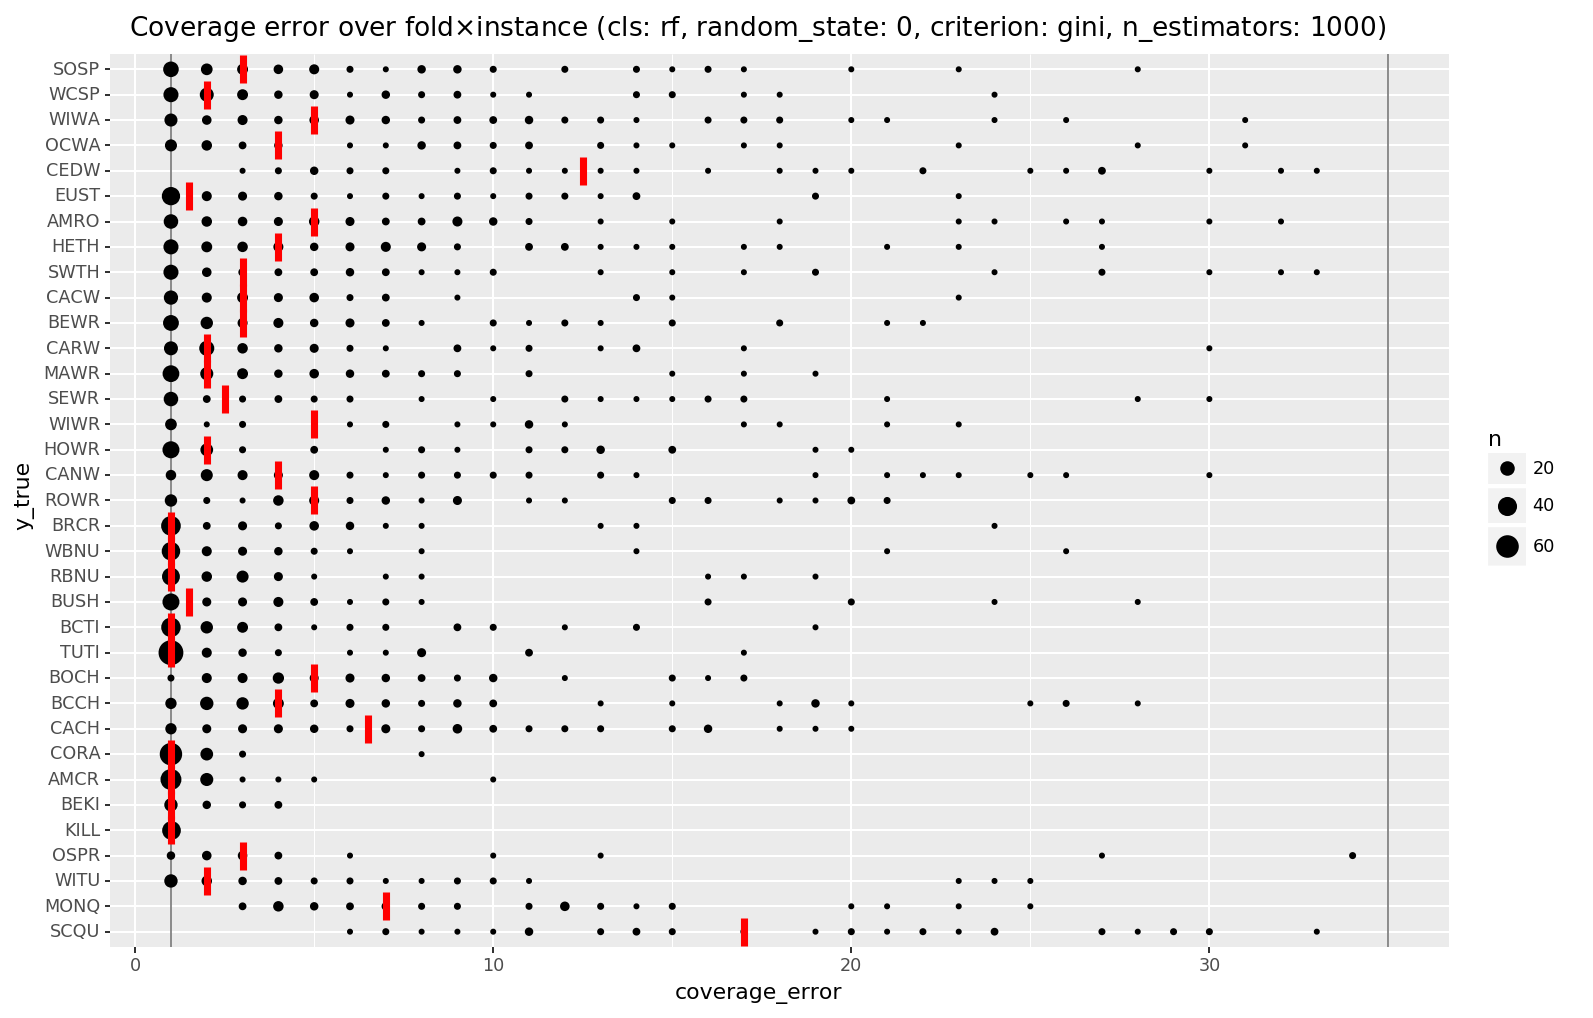

<ggplot: (320860245)>

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_ordered_cat, params=lambda df: reversed(param_grid['classifier']))
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    + theme_figsize('inline')
    + ggtitle(rf'Coverage error over fold$\times$instance ({params})')
)

In [ ]:
(coverage_errors_one_all
    [:5]
)

model_id                                                         params classifier_type  fold    i y_true  coverage_error
38520  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  172   BCTI             1.0
38521  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  464   CEDW            13.0
38522  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  196   BUSH             3.0
38523  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  414   HETH             3.0
38524  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000; fold: 0  cls: rf, random_state: 0, criterion: gini, n_estimators: 1000         rf-gini     0  531   SOSP             2.0

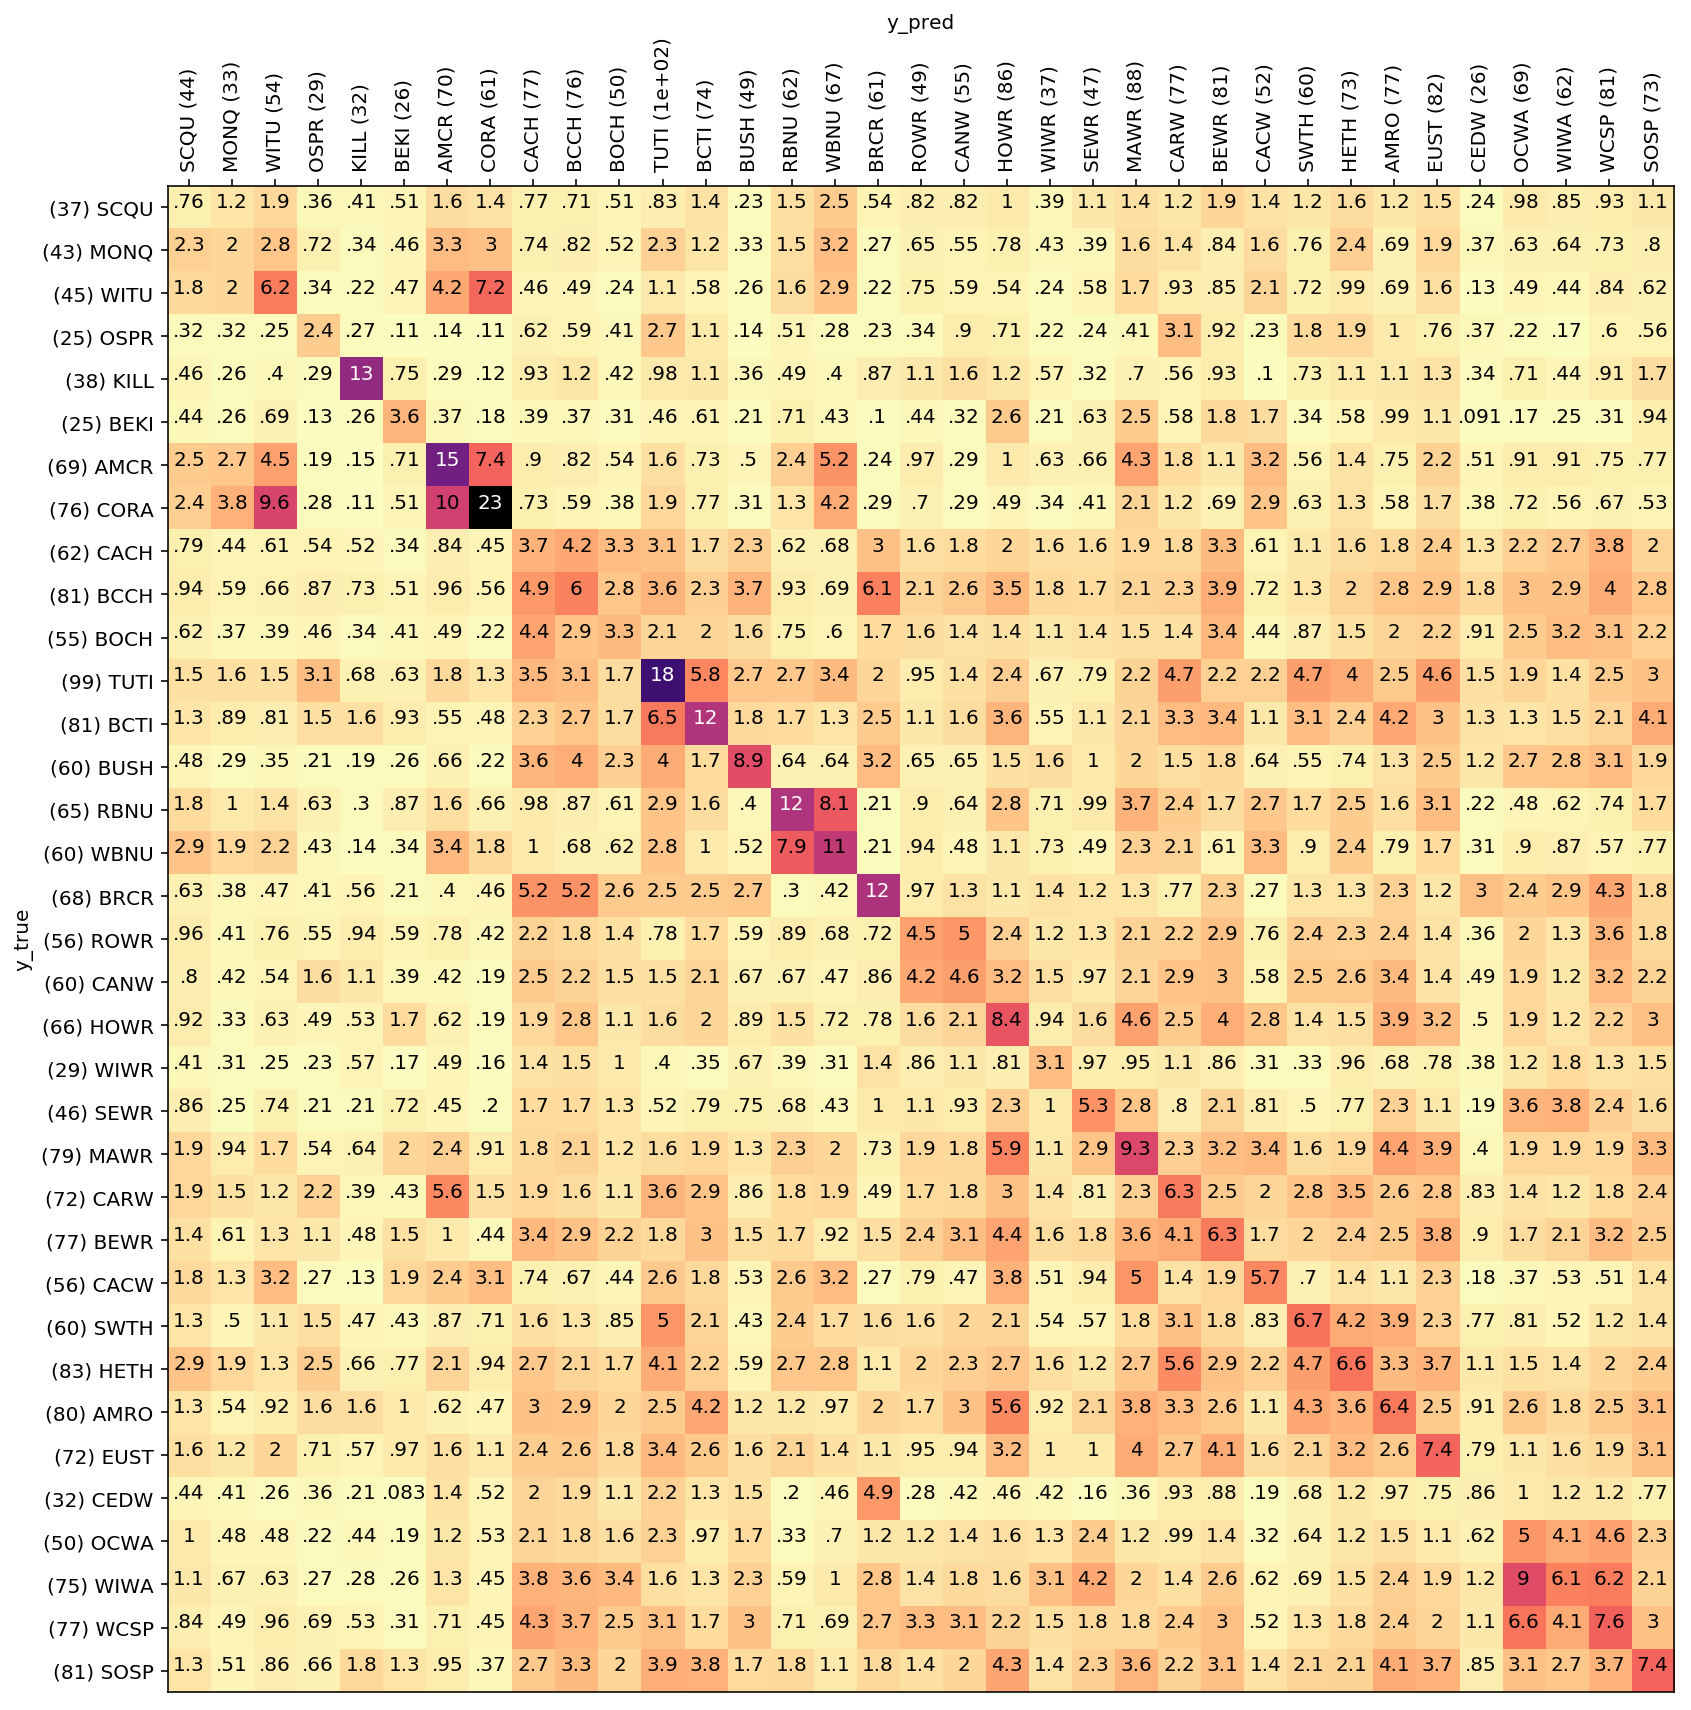

In [ ]:
# One-model/all-folds confusion matrix
with figsize('square'):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # raw=True, scale=10,  # Faster dev
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = param_grid['classifier'][params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("param_grid['classifier']:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_grid['classifier'])))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(param_grid['classifier']), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

param_grid['classifier']:
  0: 'cls: knn, n_neighbors: 1'
  1: 'cls: knn, n_neighbors: 3'
  2: 'cls: knn, n_neighbors: 5'
  3: 'cls: knn, n_neighbors: 10'
  4: 'cls: knn, n_neighbors: 25'
  5: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1'
  6: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10'
  7: 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100'
  8: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50'
  9: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100'
  10: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200'
  11: 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400'
  12: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 50'
  13: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 100'
  14: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 200'
  15: 'cls: rf, random_state: 0, criterion: gini, n_estimators: 400'
  16: 'cls: rf, random_state: 0, cri

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

107

In [ ]:
# TODO TODO What's worth recovering here, given the plots above?
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75), geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id})')
# )

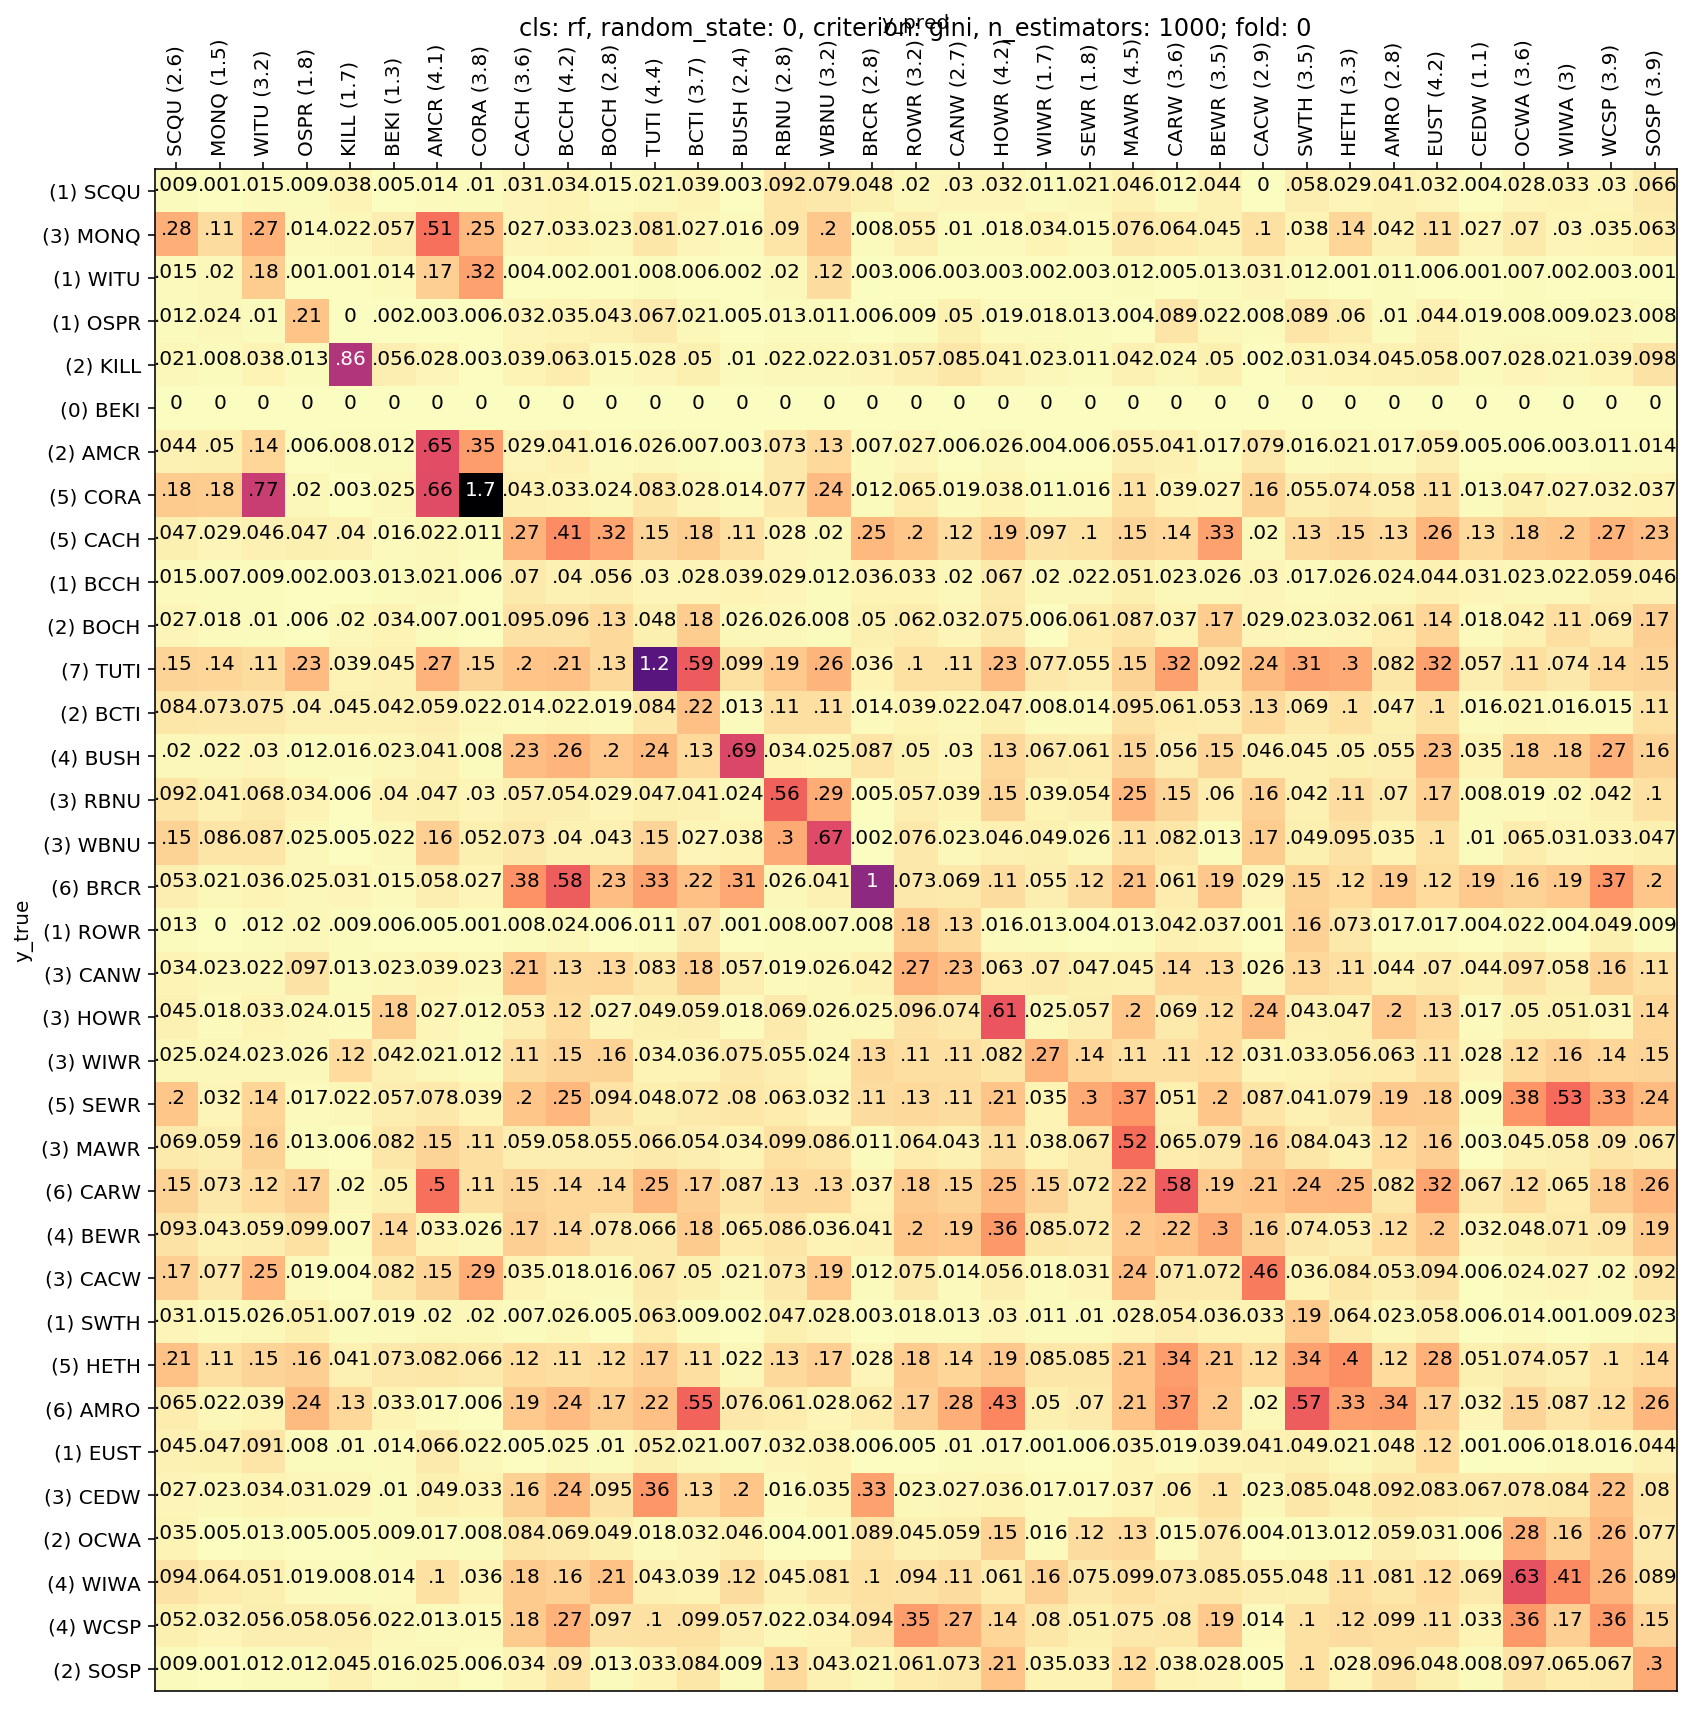

In [ ]:
# One-model/one-fold confusion matrix
with figsize('square'):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
    )